# Neural Network Models For Genre Prediction

# Dependencies
### Libraries and settings

In [ ]:
#Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import random as rnd
import seaborn as sns
from scipy.stats.mstats import winsorize

from sklearn.model_selection import train_test_split
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from sklearn.metrics import confusion_matrix

pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.6f}'.format
plt.style.use('seaborn-v0_8')

In [ ]:
plt.style.available

# Data Preparation

### Prepare a data and preprocess to an neural network input

### Types of normalization:
- All features columns normalized
- Not all features columns normalized

### All features columns normalized

In [ ]:
#Genres Dataframes
hiphop = pd.read_csv('GenresDatasetGenerator/Genres/HipHopGenre.csv')
rock = pd.read_csv('GenresDatasetGenerator/Genres/RockGenre.csv')
classical = pd.read_csv('GenresDatasetGenerator/Genres/ClassicalGenre.csv')
electronic = pd.read_csv('GenresDatasetGenerator/Genres/ElectronicGenre.csv')

genres = [hiphop, rock, classical, electronic]

def prepare_data(genres):
#----------------------------------------------------------------------------
#---prepare_data() allows to generate neccesary data as an input to a model:
#------input: genres - a list of dataframes with features for every genre
#------output: samples - an array with input samples to a model
#------------- target - an array with output target to a model
#------------- nn_dataframe - input/output dataframe
#------------- target_dict - Encoded/Decoded target dictionary
#----------------------------------------------------------------------------

    #---Feature columns used as an input to a model
    columns = ['danceability', 'energy', 'loudness', 'speechiness', 
               'acousticness', 'instrumentalness', 'liveness', 
               'valence', 'tempo', 'duration_ms', 'key', 
               'mode', 'time_signature']
    
    #---Concatenate all
    df = pd.concat(genres, ignore_index = True).set_index('Track URI')

    #---Normalization objects
    scaler = MinMaxScaler()
    encoder = LabelEncoder()

    #---Samples
    samples = scaler.fit_transform(df[columns].values) #input samples to an nn
    samples_df = pd.DataFrame(samples, columns = columns) #samples dataframe

    #---Target
    target = encoder.fit_transform(df['genres'].values) #target encoding to values
    target_df = pd.DataFrame(target, columns = ['genres']) #target dataframe

    #---Target dictionary
    encoded_target = encoder.inverse_transform(target) #target decoding to string
    target_dict = dict(zip(encoded_target, target)) #target encoding dictionary

    #---Dataframe representation
    nn_dataframe = pd.concat([samples_df, target_df], axis = 1)
    
    return samples, target, nn_dataframe

samples, target, nn_dataframe, target_dict = prepare_data(genres)

### Not all features columns normalized

In [ ]:
# Genres Dataframes
hiphop = pd.read_csv('GenresDatasetGenerator/Genres/HipHopGenre_CF.csv')
rock = pd.read_csv('GenresDatasetGenerator/Genres/RockGenre_CF.csv')
classical = pd.read_csv('GenresDatasetGenerator/Genres/ClassicalGenre_CF.csv')
electronic = pd.read_csv('GenresDatasetGenerator/Genres/ElectronicGenre_CF.csv')
alternative = pd.read_csv('GenresDatasetGenerator/Genres/AlternativeGenre_CF.csv')
pop = pd.read_csv('GenresDatasetGenerator/Genres/PopGenre_CF.csv')

# Combine genre dataframes into a list
genres = [hiphop, rock, classical, electronic, alternative, pop]

def prepare_data(genres):
    """
    prepare_data() generates necessary data as an input to a model.
    
    Args:
    - genres: a list of dataframes with features for every genre
    
    Returns:
    - samples: an array with input samples to a model
    - target: an array with output target to a model
    - nn_dataframe: input/output dataframe
    - target_dict: Encoded/Decoded target dictionary
    """
    
    # Feature columns used as input to a model
    #ready_cols = ['danceability', 'energy', 'speechiness',
    #              'acousticness', 'instrumentalness', 'liveness', 'valence']
    
    # Feature columns used as input to a model if CF
    ready_cols = ['danceability', 'energy', 'speechiness',
                  'acousticness', 'instrumentalness', 'liveness', 
                  'valence', 'danceability_energy_ratio', 'danceability_valence_ratio']
    
    nready_cols = ['loudness', 'tempo', 'duration_ms',
                   'key', 'mode', 'time_signature']
    
    # Concatenate all dataframes and reset indexes
    
    #If Track URI in columns
    df = pd.concat(genres, ignore_index=True).set_index('Track URI')
    
    #df = pd.concat(genres, ignore_index=True)
    ready_cols_df = df[ready_cols].reset_index()
    nready_cols_df = df[nready_cols]
    
    # Normalization objects
    scaler = MinMaxScaler()
    encoder = LabelEncoder()
    
    # Normalize features
    nready_cols_scaled = scaler.fit_transform(nready_cols_df.values)
    nready_cols_scaled_df = pd.DataFrame(nready_cols_scaled, columns=nready_cols)
    
     # Input to a model
    
    #If Track URI in columns
    samples_df = pd.concat([ready_cols_df.drop(columns='Track URI'), nready_cols_scaled_df], axis=1)
    
    #samples_df = pd.concat([ready_cols_df, nready_cols_scaled_df], axis=1)
    samples = samples_df.values
    
    # Target output from a model
    target = encoder.fit_transform(df['genres'].values)
    target_df = pd.DataFrame(target, columns=['genres'])
    
    # Target dictionary
    encoded_target = encoder.inverse_transform(target)
    target_dict = dict(zip(encoded_target, target))
    target_dict = dict(sorted(target_dict.items()))
    
    # Dataframe representation
    nn_dataframe = pd.concat([samples_df, target_df], axis=1)
    
    return samples, target, nn_dataframe, target_dict

# Call the function and assign the returned values
samples, target, nn_dataframe, target_dict = prepare_data(genres)

In [ ]:
nn_dataframe

In [ ]:
# Data to filter by feature
classical = pd.read_csv('GenresDatasetGenerator/Genres/ClassicalGenre.csv')

# Exploratory Data Analysis
### In depth look into data

## Look for data structure
 - KDE plots for features
 - Scatterplots

In [ ]:
#KDE Plot for features
def plot_kde_subplots(dataframe):
    num_cols = 3
    num_rows = (dataframe.shape[1] - 1) // num_cols + 1

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 16))
    axes = axes.flatten()

    for i, column in enumerate(dataframe.columns[:-1]):
        ax = axes[i]
        sns.kdeplot(data=dataframe, x=column, hue='genres', bw_adjust=0.5, ax=ax)
        ax.set_title(column)
        
    for j in range(len(dataframe.columns[:-1]), len(axes)):
         fig.delaxes(axes[j])

    fig.tight_layout()
    plt.show()

print(pd.DataFrame(target_dict.values(), target_dict.keys(), columns = ['codes']))
plot_kde_subplots(nn_dataframe)


In [ ]:
#Scatter Plot for features
sns.scatterplot(data = nn_dataframe, x = 'energy', y = 'danceability', hue = 'genres', )

## Data filtering
 - Kernel Density Estimation Trimming
 - Populating Median Neighbourhood
 - Features Extracting

### Kernel Density Estimation Trimming

In [ ]:
#Kernel Density Estimation Trimming

#Original Genres data for reseting
hiphop = pd.read_csv('GenresDatasetGenerator/Genres/HipHopGenre.csv')
rock = pd.read_csv('GenresDatasetGenerator/Genres/RockGenre.csv')
classical = pd.read_csv('GenresDatasetGenerator/Genres/ClassicalGenre.csv')
electronic = pd.read_csv('GenresDatasetGenerator/Genres/ElectronicGenre.csv')
alternative = pd.read_csv('GenresDatasetGenerator/Genres/AlternativeGenre.csv')
pop = pd.read_csv('GenresDatasetGenerator/Genres/PopGenre.csv')

genres = [hiphop, rock, classical, electronic, alternative, pop]

samples, target, nn_dataframe, target_dict = prepare_data(genres)

In [ ]:
#Take a dataframe and trim by feature

hiphop = hiphop[(hiphop['danceability'] > 0.7) & (hiphop['danceability'] < 1)]
hiphop = hiphop[(hiphop['energy'] > 0.4) & (hiphop['energy'] < 0.8)]

rock = rock[(rock['danceability'] > 0.4) & (rock['danceability'] < 0.6)]
rock = rock[(rock['danceability'] > 0.5) & (rock['danceability'] < 1)]

classical = classical[(classical['danceability'] > 0.1) & (classical['danceability'] < 0.4)]

electronic = electronic[(electronic['danceability'] > 0.6) & (electronic['danceability'] < 0.75)]
electronic = electronic[(electronic['energy'] > 0.6) & (electronic['danceability'] < 1)]

alternative = alternative[(alternative['danceability'] > 0.5) & (alternative['danceability'] < 0.7)]

pop = pop[(pop['danceability'] > 0.6) & (pop['danceability'] < 0.9)]
pop = pop[(pop['energy'] > 0.4) & (pop['energy'] < 0.9)]

genres = [hiphop, rock, classical, electronic, alternative, pop]

#Initialize trimming
samples, target, nn_dataframe, target_dict = prepare_data_new_features(genres)

In [ ]:
#Feature KDE
sns.kdeplot(data = nn_dataframe, x = 'danceability', hue = 'genres', bw_adjust=0.5)
print(target_dict)
print(nn_dataframe.columns)

In [ ]:
#Plot for one feature
sns.kdeplot(data = classical['tempo'], bw_adjust=0.5)

### Populating Median Neighbourhood

In [ ]:
#Populating Median Neighbourhood

#Original Genres data for reseting
hiphop = pd.read_csv('GenresDatasetGenerator/Genres/HipHopGenre.csv')
rock = pd.read_csv('GenresDatasetGenerator/Genres/RockGenre.csv')
classical = pd.read_csv('GenresDatasetGenerator/Genres/ClassicalGenre.csv')
electronic = pd.read_csv('GenresDatasetGenerator/Genres/ElectronicGenre.csv')
alternative = pd.read_csv('GenresDatasetGenerator/Genres/AlternativeGenre.csv')
pop = pd.read_csv('GenresDatasetGenerator/Genres/PopGenre.csv')

genres = [hiphop, rock, classical, electronic, alternative, pop]

samples, target, nn_dataframe, target_dict = prepare_data(genres)

In [ ]:
#Take a dataframe and populate

#Choose a genre to populate
#{'Alternative': 0, 'Classical': 1, 'Electronic': 2, 'HipHop': 3, 'Pop': 4, 'Rock': 5}

def create_sample(genre):
    
    genre_df = genre[['danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature']]
    features = genre_df.columns
    
    random_features = []
    for feature in features:
        p25 = genre_df[feature].describe()[4]
        p75 = genre_df[feature].describe()[6]
        random_value = rnd.uniform(p25, p75)
        random_features.append(random_value)
   
    sample = pd.DataFrame(data=[random_features], columns=features)
    sample['genres'] = genre['genres']
    sample[['key', 'mode', 'time_signature']] = sample[['key', 'mode', 'time_signature']].astype(int)
    
    return sample

#create_sample(classical)

In [ ]:
def populate(genre, r):
    columns = ['Unnamed: 0', 'Track URI', 'danceability', 'energy', 'key', 'loudness',
               'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
               'valence', 'tempo', 'duration_ms', 'time_signature', 'genres']

    df = pd.DataFrame(columns=columns)

    i = 0
    for i in range(r):
        sample = create_sample(genre)
        sample['Unnamed: 0'] = 0  # Fill 'Unnamed: 0' with a placeholder value
        sample['Track URI'] = 'placeholder'  # Fill 'Track URI' with a placeholder value
        df = pd.concat([df, sample], ignore_index=True)
        i = i + 1


    populated_df = pd.concat([genre, df])
    
    return populated_df

alternative = populate(alternative, 10)
classical = populate(classical, 10)
electronic = populate(electronic, 10)
hiphop = populate(hiphop, 10)
pop = populate(pop, 10)
rock = populate(rock, 10)


In [ ]:
genres = [hiphop, rock, classical, electronic, alternative, pop]
samples, target, nn_dataframe, target_dict = prepare_data(genres)

In [ ]:
nn_dataframe

In [ ]:
#Feature KDE
sns.kdeplot(data = nn_dataframe, x = 'danceability', hue = 'genres', bw_adjust=0.5)
print(target_dict)
print(nn_dataframe.columns)

In [ ]:
#Plot for one feature
sns.kdeplot(data = classical['danceability'], bw_adjust=0.5)

### Features Extracting

In [ ]:
#Additional features extracting

#Original Genres data for reseting
hiphop = pd.read_csv('GenresDatasetGenerator/Genres/HipHopGenre.csv')
rock = pd.read_csv('GenresDatasetGenerator/Genres/RockGenre.csv')
classical = pd.read_csv('GenresDatasetGenerator/Genres/ClassicalGenre.csv')
electronic = pd.read_csv('GenresDatasetGenerator/Genres/ElectronicGenre.csv')
alternative = pd.read_csv('GenresDatasetGenerator/Genres/AlternativeGenre.csv')
pop = pd.read_csv('GenresDatasetGenerator/Genres/PopGenre.csv')

genres = [hiphop, rock, classical, electronic, alternative, pop]

samples, target, nn_dataframe, target_dict = prepare_data(genres)

In [ ]:
def prepare_data_new_features(genres):
    """
    prepare_data() generates necessary data as an input to a model.
    
    Args:
    - genres: a list of dataframes with features for every genre
    
    Returns:
    - samples: an array with input samples to a model
    - target: an array with output target to a model
    - nn_dataframe: input/output dataframe
    - target_dict: Encoded/Decoded target dictionary
    """
    
    # Feature columns used as input to a model
    ready_cols = ['danceability', 'energy', 'speechiness',
                  'acousticness', 'instrumentalness', 'liveness', 
                  'valence', 'danceability_energy_ratio', 'danceability_loudness_ratio']
    nready_cols = ['loudness', 'tempo', 'duration_ms',
                   'key', 'mode', 'time_signature']
    
    # Concatenate all dataframes and reset indexes
    df = pd.concat(genres, ignore_index=True).set_index('Track URI')
    ready_cols_df = df[ready_cols].reset_index()
    nready_cols_df = df[nready_cols]
    
    # Normalization objects
    scaler = MinMaxScaler()
    encoder = LabelEncoder()
    
    # Normalize features
    nready_cols_scaled = scaler.fit_transform(nready_cols_df.values)
    nready_cols_scaled_df = pd.DataFrame(nready_cols_scaled, columns=nready_cols)
    
    # Input to a model
    samples_df = pd.concat([ready_cols_df.drop(columns='Track URI'), nready_cols_scaled_df], axis=1)
    samples = samples_df.values
    
    # Target output from a model
    target = encoder.fit_transform(df['genres'].values)
    target_df = pd.DataFrame(target, columns=['genres'])
    
    # Target dictionary
    encoded_target = encoder.inverse_transform(target)
    target_dict = dict(zip(encoded_target, target))
    target_dict = dict(sorted(target_dict.items()))
    
    # Dataframe representation
    nn_dataframe = pd.concat([samples_df, target_df], axis=1)
    
    return samples, target, nn_dataframe, target_dict

In [ ]:
for genre in genres:
    genre['danceability_energy_ratio'] = genre['danceability'] * genre['energy']
    genre['danceability_loudness_ratio'] = genre['danceability'] * genre['valence']

genres = [hiphop, rock, classical, electronic, alternative, pop]

samples, target, nn_dataframe, target_dict = prepare_data_new_features(genres)

In [ ]:
#Feature KDE
sns.kdeplot(data = nn_dataframe, x = 'danceability_loudness_ratio', hue = 'genres', bw_adjust=0.5)
print(target_dict)
print(nn_dataframe.columns)

In [ ]:
nn_dataframe

# Model
### Create an neural network and hyperparameter tuning
- Model architecture optimization - create a neural network model object and use a tuner to optimize in terms of architecture
- Main model - Create own neural network model

In [ ]:
#---Data split
X_train, X_test, y_train, y_test = train_test_split(samples, target)

In [ ]:
X_train.shape

### Model architecture optimization

In [ ]:
def model_builder(hp):
#--------------------------------------------------------------------------------
#---model_builder() allows to build model architecture for hyperparameter tuning
#--------------------------------------------------------------------------------

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape = (13, 1)))
    
    hp_activation = hp.Choice('activation', values = ['relu', 'tanh'])
    hp_layer_1 = hp.Int('layer_1', min_value = 16, max_value = 128, step = 16)
    hp_layer_2 = hp.Int('layer_2', min_value = 0, max_value = 128, step = 16)
              
    model.add(tf.keras.layers.Dense(units = hp_layer_1, activation = hp_activation))
    model.add(tf.keras.layers.Dense(units = hp_layer_2, activation = hp_activation))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(6, activation = 'softmax'))
              
    model.compile(optimizer = tf.keras.optimizers.Adam(),
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics = ['accuracy'])
              
    return model

In [ ]:
#---Available tuners
hb_tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy',
                     max_epochs = 100,
                     factor = 3,
                     directory = 'keras-tuner',
                     overwrite = True,
                     project_name = 'test')

rs_tuner = kt.RandomSearch(model_builder,
                         objective="val_accuracy",
                         max_trials=10,
                         executions_per_trial=2,
                         overwrite=True,
                         directory="keras-tuner",
                         project_name="testt")

gs_tuner = kt.GridSearch(model_builder,
                         objective = 'val_accuracy',
                         max_trials = 20,
                         directory = 'keras-tuner',
                         overwrite = True,
                         project_name = 'best_model_gstuner')

In [ ]:
#---Optimizator definition
def tuner(tuner):
    stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
    tuner.search(X_train, y_train, epochs = 100, validation_split = 0.2, callbacks = [stop_early])
    #tuner.results_summary()
    best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
    model = tuner.hypermodel.build(best_hps)
    model.summary()
    
    return model

model = tuner(gs_tuner) #build a tuner 

In [ ]:
#---Training characteristics
history = model.fit(X_train, y_train, batch_size = 32, epochs = 80, verbose = 0, validation_split = 0.2)

#Plot training and validation loss
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))

axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

#Plot training and validation accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

### Main model

In [ ]:
def create_model(input_shape):
    """
    create_model() allows customizing and building a model.
    
    Args:
    - input_shape: shape of the input
    
    Returns:
    - model: neural network model
    """
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    
    # Compiler
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    model.compile(optimizer='adam',
                  loss=loss_func,
                  metrics=['accuracy'])
    
    return model

# Call the function and assign the returned model
model = create_model(input_shape=(15, 1))

In [ ]:
def train_model(model, X_train, y_train):
    """
    train_model() trains a model and plots training characteristics.
    
    Args:
    - model: neural network architecture
    - X_train, y_train: input and target output
    
    Returns:
    - trained_model: trained neural network
    """
    
    # Train the model
    trained_model = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0, validation_split=0.2)
    
    # Plot training and validation loss
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
    axes[0].plot(trained_model.history['loss'], label='Training Loss')
    axes[0].plot(trained_model.history['val_loss'], label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    # Plot training and validation accuracy
    axes[1].plot(trained_model.history['accuracy'], label='Training Accuracy')
    axes[1].plot(trained_model.history['val_accuracy'], label='Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return trained_model

# Call the function and assign the returned trained model
trained_model = train_model(model, X_train, y_train)

In [ ]:
def evaluate_model(model, X_test, y_test):
    """
    evaluate_model() evaluates a model on test data.
    
    Args:
    - model: neural network architecture
    - X_test, y_test: input and target output
    
    Returns:
    - None
    """
    
    # Evaluating to check performance
    model.evaluate(X_test, y_test, verbose=2)
    
    return

# Call the function
evaluate_model(model, X_test, y_test)

### Confusion matrix for test data

In [ ]:
#Prediction accuracy using predict method
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
accuracy = np.mean(predicted_labels == y_test)
print('Accuracy:', accuracy)

#---Confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

#---Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_dict.keys(), yticklabels=target_dict.keys())

#---Set axis labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

#---Show the plot
plt.show()

### Save/Load model

In [ ]:
#Save model
# Save the weights
model.save_weights('models/models1')

In [ ]:
#Load model
# Restore the weights
model.load_weights('models/models1')

# Predictions
### Predict and visualize

### Main model predictions on a test data in barplot style

In [ ]:
#Predictions probabilities in barplot style
def plot_predictions(predictions):

    num_predictions = len(predictions)
    num_subplots = 4  # Assuming 2 subplots per row, you can adjust as needed
    num_rows = (num_predictions + num_subplots - 1) // num_subplots

    fig, axs = plt.subplots(num_rows, num_subplots, figsize=(14, 2 * num_rows))

    for i, prediction in enumerate(predictions):
        row = i // num_subplots
        col = i % num_subplots

        ax = axs[row, col]
        ax.bar(range(len(prediction)), prediction)
        ax.set_xlabel('Categories')
        ax.set_ylabel('Probability')
        ax.set_title(f'Prediction {i+1}')

    # Adjust the spacing between subplots
    fig.tight_layout()

    # Display the plot
    plt.show()
    
plot_predictions(predictions.tolist()[:12])

In [ ]:
#Predictions probabilities dataframe
prediction_df = pd.DataFrame(data = predictions, columns = target_dict.keys())
prediction_df

### Main model predictions for unknown data
- Prepare a new data and preprocess as an neural network input

In [ ]:
#Predictions for unknown data
def data_prep(df):
    
    ready_cols = ['danceability', 'energy', 'speechiness', 
                  'acousticness', 'instrumentalness', 'liveness', 'valence']
    nready_cols = ['loudness', 'tempo', 'duration_ms', 
                   'key', 'mode', 'time_signature']

    #---Concatenate all and reset indexes
    df = df.set_index('Track URI')
    ready_cols_df = df[ready_cols].reset_index()
    nready_cols_df = df[nready_cols]

    #---Normalization objects
    scaler = MinMaxScaler()
    encoder = LabelEncoder()

    #---Normalize features
    #------nready_cols_scaled - transformed data
    #------nready_cols_scaled_df - dataframe
    nready_cols_scaled = scaler.fit_transform(nready_cols_df.values) 
    nready_cols_scaled_df = pd.DataFrame(nready_cols_scaled, columns = nready_cols)
    
    #---Input to a model
    samples_df = pd.concat([ready_cols_df.drop(columns = 'Track URI'), nready_cols_scaled_df], axis = 1)
    samples = samples_df.values
    
    return samples, samples_df

data = pd.read_csv('GenresDatasetGenerator/Albums/JACKBOYS.csv')
test_samples, test_samples_df = data_prep(data)

### Prediction barplot for song

In [ ]:
predictions_unkn = model.predict(test_samples)

labels = list(target_dict.keys())
indices = list(target_dict.values())

# Create a bar plot
plt.bar(indices, predictions_unkn.flatten())

# Set the tick labels and title
plt.xticks(indices, labels)
plt.xlabel('Genres')
plt.ylabel('Prediction Probability')
plt.title('Predicted Probabilities for Genres')

# Display the plot
plt.show()

### Prediction barplot for playlist

In [ ]:
predictions = model.predict(test_samples)
plot_predictions(predictions)

### Histogram for genres count

In [ ]:
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels_keys = [key for value in predicted_labels for key, val in target_dict.items() if val == value]
sns.histplot(data = predicted_labels_keys, discrete = True)

### Model prediction uncertainty

In [ ]:
#Predictions probabilities dataframe
prediction_df = pd.DataFrame(data = predictions, columns = target_dict.keys())
#prediction_df

In [ ]:
uncertainty = []
for i in range(prediction_df.shape[0]):
    pred_uncertainty = prediction_df.iloc[i].sort_values(ascending = False)[0] - prediction_df.iloc[i].sort_values(ascending = False)[1]
    uncertainty.append(pred_uncertainty)

uncertainty_df = pd.DataFrame(data = uncertainty, columns = ['Uncertainty Value'])
#uncertainty_df = uncertainty_df.sort_values(by = 'Uncertainty Value', ascending = False) # No need for sorting, seaborn handle this
#uncertainty_df

In [ ]:
sns.kdeplot(data = uncertainty_df, x = 'Uncertainty Value', bw_adjust=0.2)

# ---------------------------------------------------------------------------------------------------------------------------------
# Working modules
# ---------------------------------------------------------------------------------------------------------------------------------

## ---------------------------------------------------------------------------------------------------------------------------------
## ------Neural network training on a raw genre datasets
## ---------------------------------------------------------------------------------------------------------------------------------

### Functions:

In [ ]:
def prepare_data(genres):
    """
    prepare_data() generates necessary data as an input to a model.
    
    Args:
    - genres: a list of dataframes with features for every genre
    
    Returns:
    - samples: an array with input samples to a model
    - target: an array with output target to a model
    - nn_dataframe: input/output dataframe
    - target_dict: Encoded/Decoded target dictionary
    """
    
    # Feature columns used as input to a model
    ready_cols = ['danceability', 'energy', 'speechiness',
                  'acousticness', 'instrumentalness', 'liveness', 'valence']
    nready_cols = ['loudness', 'tempo', 'duration_ms',
                   'key', 'mode', 'time_signature']
    
    # Concatenate all dataframes and reset indexes
    df = pd.concat(genres, ignore_index=True).set_index('Track URI')
    ready_cols_df = df[ready_cols].reset_index()
    nready_cols_df = df[nready_cols]
    
    # Normalization objects
    scaler = MinMaxScaler()
    encoder = LabelEncoder()
    
    # Normalize features
    nready_cols_scaled = scaler.fit_transform(nready_cols_df.values)
    nready_cols_scaled_df = pd.DataFrame(nready_cols_scaled, columns=nready_cols)
    
    # Input to a model
    samples_df = pd.concat([ready_cols_df.drop(columns='Track URI'), nready_cols_scaled_df], axis=1)
    samples = samples_df.values
    
    # Target output from a model
    target = encoder.fit_transform(df['genres'].values)
    target_df = pd.DataFrame(target, columns=['genres'])
    
    # Target dictionary
    encoded_target = encoder.inverse_transform(target)
    target_dict = dict(zip(encoded_target, target))
    target_dict = dict(sorted(target_dict.items()))
    
    # Dataframe representation
    nn_dataframe = pd.concat([samples_df, target_df], axis=1)
    
    return samples, target, nn_dataframe, target_dict

def create_model(input_shape):
    """
    create_model() allows customizing and building a model.
    
    Args:
    - input_shape: shape of the input
    
    Returns:
    - model: neural network model
    """
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(64, activation='relu'),
        #tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    
    # Compiler
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    model.compile(optimizer='adam',
                  loss=loss_func,
                  metrics=['accuracy'])
    
    return model

def train_model(model, X_train, y_train):
    """
    train_model() trains a model and plots training characteristics.
    
    Args:
    - model: neural network architecture
    - X_train, y_train: input and target output
    
    Returns:
    - trained_model: trained neural network
    """
    
    # Train the model
    trained_model = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0, validation_split=0.2)
    
    # Plot training and validation loss
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
    axes[0].plot(trained_model.history['loss'], label='Training Loss')
    axes[0].plot(trained_model.history['val_loss'], label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    # Plot training and validation accuracy
    axes[1].plot(trained_model.history['accuracy'], label='Training Accuracy')
    axes[1].plot(trained_model.history['val_accuracy'], label='Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return trained_model

def evaluate_model(model, X_test, y_test):
    """
    evaluate_model() evaluates a model on test data.
    
    Args:
    - model: neural network architecture
    - X_test, y_test: input and target output
    
    Returns:
    - None
    """
    
    # Evaluating to check performance
    model.evaluate(X_test, y_test, verbose=2)
    
    return

### Load raw data

In [31]:
# Populated Genres Dataframes
hiphop = pd.read_csv('GenresDatasetGenerator/Genres/HipHopGenre_pop.csv')
rock = pd.read_csv('GenresDatasetGenerator/Genres/RockGenre_pop.csv')
classical = pd.read_csv('GenresDatasetGenerator/Genres/ClassicalGenre_pop.csv')
electronic = pd.read_csv('GenresDatasetGenerator/Genres/ElectronicGenre_pop.csv')
alternative = pd.read_csv('GenresDatasetGenerator/Genres/AlternativeGenre_pop.csv')
pop = pd.read_csv('GenresDatasetGenerator/Genres/PopGenre_pop.csv')

#Combine genre dataframes into a list
genres = [hiphop, rock, classical, electronic, alternative, pop]

In [ ]:
# Raw Genres Dataframes
hiphop = pd.read_csv('GenresDatasetGenerator/Genres/HipHopGenre.csv')
rock = pd.read_csv('GenresDatasetGenerator/Genres/RockGenre.csv')
classical = pd.read_csv('GenresDatasetGenerator/Genres/ClassicalGenre.csv')
electronic = pd.read_csv('GenresDatasetGenerator/Genres/ElectronicGenre.csv')
alternative = pd.read_csv('GenresDatasetGenerator/Genres/AlternativeGenre.csv')
pop = pd.read_csv('GenresDatasetGenerator/Genres/PopGenre.csv')

#Combine genre dataframes into a list
genres = [hiphop, rock, classical, electronic, alternative, pop]

### Train a model

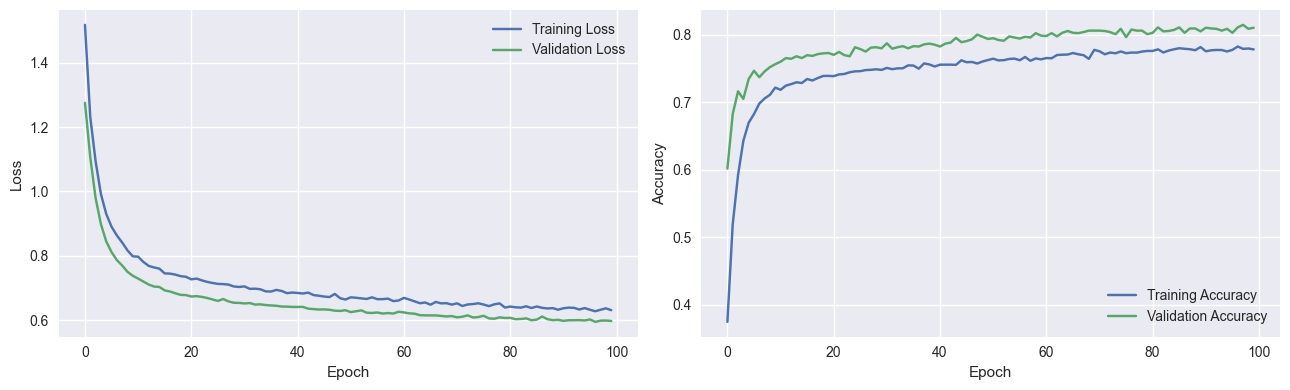

98/98 - 0s - loss: 0.5974 - accuracy: 0.7943 - 77ms/epoch - 787us/step


In [32]:
# Create and preprocess training data
samples, target, nn_dataframe, target_dict = prepare_data(genres)

# Data split
X_train, X_test, y_train, y_test = train_test_split(samples, target)

# Create a model
model = create_model(input_shape=(13, 1))

# Train a model
trained_model = train_model(model, X_train, y_train)

# Evaluate on a test set
evaluate_model(model, X_test, y_test)

### Visualize

98/98 [==============================] - 0s 619us/step
Accuracy: 0.794344473007712


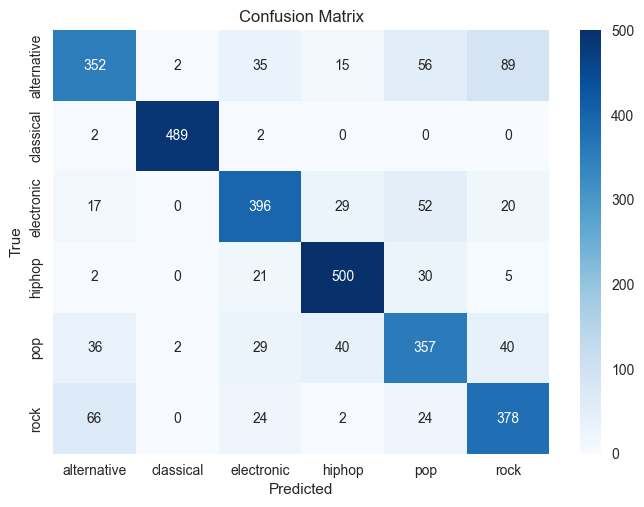

In [33]:
#Prediction accuracy using predict method
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
accuracy = np.mean(predicted_labels == y_test)
print('Accuracy:', accuracy)

#---Confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

#---Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_dict.keys(), yticklabels=target_dict.keys())

#---Set axis labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

#---Show the plot
plt.show()

In [ ]:
#Predictions probabilities in barplot style
def plot_predictions(predictions):

    num_predictions = len(predictions)
    num_subplots = 4  # Assuming 2 subplots per row, you can adjust as needed
    num_rows = (num_predictions + num_subplots - 1) // num_subplots

    fig, axs = plt.subplots(num_rows, num_subplots, figsize=(14, 2 * num_rows))

    for i, prediction in enumerate(predictions):
        row = i // num_subplots
        col = i % num_subplots

        ax = axs[row, col]
        ax.bar(range(len(prediction)), prediction)
        ax.set_xlabel('Categories')
        ax.set_ylabel('Probability')
        ax.set_title(f'Prediction {i+1}')

    # Adjust the spacing between subplots
    fig.tight_layout()

    # Display the plot
    plt.show()
    
plot_predictions(predictions.tolist()[:12])

### Save a model

In [ ]:
#Save model
# Save the weights
model.save_weights('models/populate_data_model')

## ---------------------------------------------------------------------------------------------------------------------------------
## ------Neural network training on a modified genre datasets
## ---------------------------------------------------------------------------------------------------------------------------------

### Functions

In [34]:
def prepare_data(genres):
    """
    prepare_data() generates necessary data as an input to a model.
    
    Args:
    - genres: a list of dataframes with features for every genre
    
    Returns:
    - samples: an array with input samples to a model
    - target: an array with output target to a model
    - nn_dataframe: input/output dataframe
    - target_dict: Encoded/Decoded target dictionary
    """
    
    # Feature columns used as input to a model
    ready_cols = ['danceability', 'energy', 'speechiness',
                  'acousticness', 'instrumentalness', 'liveness', 'valence']
    nready_cols = ['loudness', 'tempo', 'duration_ms',
                   'key', 'mode', 'time_signature']
    
    # Concatenate all dataframes and reset indexes
    df = pd.concat(genres, ignore_index=True).set_index('Track URI')
    ready_cols_df = df[ready_cols].reset_index()
    nready_cols_df = df[nready_cols]
    
    # Normalization objects
    scaler = MinMaxScaler()
    encoder = LabelEncoder()
    
    # Normalize features
    nready_cols_scaled = scaler.fit_transform(nready_cols_df.values)
    nready_cols_scaled_df = pd.DataFrame(nready_cols_scaled, columns=nready_cols)
    
    # Input to a model
    samples_df = pd.concat([ready_cols_df.drop(columns='Track URI'), nready_cols_scaled_df], axis=1)
    samples = samples_df.values
    
    # Target output from a model
    target = encoder.fit_transform(df['genres'].values)
    target_df = pd.DataFrame(target, columns=['genres'])
    
    # Target dictionary
    encoded_target = encoder.inverse_transform(target)
    target_dict = dict(zip(encoded_target, target))
    target_dict = dict(sorted(target_dict.items()))
    
    # Dataframe representation
    nn_dataframe = pd.concat([samples_df, target_df], axis=1)
    
    return samples, target, nn_dataframe, target_dict

def prepare_data_new_features(genres):
    """
    prepare_data() generates necessary data as an input to a model.
    
    Args:
    - genres: a list of dataframes with features for every genre
    
    Returns:
    - samples: an array with input samples to a model
    - target: an array with output target to a model
    - nn_dataframe: input/output dataframe
    - target_dict: Encoded/Decoded target dictionary
    """
    
    # Feature columns used as input to a model
    ready_cols = ['danceability', 'energy', 'speechiness',
                  'acousticness', 'instrumentalness', 'liveness', 
                  'valence', 'danceability_energy_ratio', 'danceability_valence_ratio']
    nready_cols = ['loudness', 'tempo', 'duration_ms',
                   'key', 'mode', 'time_signature']
    
    # Concatenate all dataframes and reset indexes
    df = pd.concat(genres, ignore_index=True).set_index('Track URI')
    ready_cols_df = df[ready_cols].reset_index()
    nready_cols_df = df[nready_cols]
    
    # Normalization objects
    scaler = MinMaxScaler()
    encoder = LabelEncoder()
    
    # Normalize features
    nready_cols_scaled = scaler.fit_transform(nready_cols_df.values)
    nready_cols_scaled_df = pd.DataFrame(nready_cols_scaled, columns=nready_cols)
    
    # Input to a model
    samples_df = pd.concat([ready_cols_df.drop(columns='Track URI'), nready_cols_scaled_df], axis=1)
    samples = samples_df.values
    
    # Target output from a model
    target = encoder.fit_transform(df['genres'].values)
    target_df = pd.DataFrame(target, columns=['genres'])
    
    # Target dictionary
    encoded_target = encoder.inverse_transform(target)
    target_dict = dict(zip(encoded_target, target))
    target_dict = dict(sorted(target_dict.items()))
    
    # Dataframe representation
    nn_dataframe = pd.concat([samples_df, target_df], axis=1)
    
    return samples, target, nn_dataframe, target_dict

def create_sample(genre):
    
    genre_df = genre[['danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature']]
    features = genre_df.columns
    
    random_features = []
    for feature in features:
        p25 = genre_df[feature].describe()[4]
        p75 = genre_df[feature].describe()[6]
        random_value = rnd.uniform(p25, p75)
        random_features.append(random_value)
   
    sample = pd.DataFrame(data=[random_features], columns=features)
    sample['genres'] = genre['genres']
    sample[['key', 'mode', 'time_signature']] = sample[['key', 'mode', 'time_signature']].astype(int)
    
    return sample

def populate(genre, r):
    columns = ['Unnamed: 0', 'Track URI', 'danceability', 'energy', 'key', 'loudness',
               'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
               'valence', 'tempo', 'duration_ms', 'time_signature', 'genres']

    df = pd.DataFrame(columns=columns)

    i = 0
    for i in range(r):
        sample = create_sample(genre)
        sample['Unnamed: 0'] = 0  # Fill 'Unnamed: 0' with a placeholder value
        sample['Track URI'] = 'placeholder'  # Fill 'Track URI' with a placeholder value
        df = pd.concat([df, sample], ignore_index=True)
        i = i + 1


    populated_df = pd.concat([genre, df])
    
    return populated_df

def create_model(input_shape):
    """
    create_model() allows customizing and building a model.
    
    Args:
    - input_shape: shape of the input
    
    Returns:
    - model: neural network model
    """
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    
    # Compiler
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    model.compile(optimizer='adam',
                  loss=loss_func,
                  metrics=['accuracy'])
    
    return model

def train_model(model, X_train, y_train):
    """
    train_model() trains a model and plots training characteristics.
    
    Args:
    - model: neural network architecture
    - X_train, y_train: input and target output
    
    Returns:
    - trained_model: trained neural network
    """
    
    # Train the model
    trained_model = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0, validation_split=0.2)
    
    # Plot training and validation loss
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
    axes[0].plot(trained_model.history['loss'], label='Training Loss')
    axes[0].plot(trained_model.history['val_loss'], label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    # Plot training and validation accuracy
    axes[1].plot(trained_model.history['accuracy'], label='Training Accuracy')
    axes[1].plot(trained_model.history['val_accuracy'], label='Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return trained_model

def evaluate_model(model, X_test, y_test):
    """
    evaluate_model() evaluates a model on test data.
    
    Args:
    - model: neural network architecture
    - X_test, y_test: input and target output
    
    Returns:
    - None
    """
    
    # Evaluating to check performance
    model.evaluate(X_test, y_test, verbose=2)
    
    return

### Initialize raw data

In [43]:
#Original Genres data
hiphop = pd.read_csv('GenresDatasetGenerator/Genres/HipHopGenre_pop.csv')
rock = pd.read_csv('GenresDatasetGenerator/Genres/RockGenre_pop.csv')
classical = pd.read_csv('GenresDatasetGenerator/Genres/ClassicalGenre_pop.csv')
electronic = pd.read_csv('GenresDatasetGenerator/Genres/ElectronicGenre_pop.csv')
alternative = pd.read_csv('GenresDatasetGenerator/Genres/AlternativeGenre_pop.csv')
pop = pd.read_csv('GenresDatasetGenerator/Genres/PopGenre_pop.csv')

genres = [hiphop, rock, classical, electronic, alternative, pop]

### Data optimization methods
#### (I) Populating Median Neigbourhood
#### (II) Feature Extracting
#### (III) KDE Trimming

### (I) Populating Median Neighbourhood

#### Populate dataframe

In [ ]:
alternative = populate(alternative, 100)
classical = populate(classical, 100)
electronic = populate(electronic, 100)
hiphop = populate(hiphop, 100)
pop = populate(pop, 100)
rock = populate(rock, 100)

genres = [hiphop, rock, classical, electronic, alternative, pop]

### (II) Feature Extracting

#### Add new features and prepare data

In [45]:
for genre in genres:
    genre['danceability_energy_ratio'] = genre['danceability'] * genre['energy']
    genre['danceability_valence_ratio'] = genre['danceability'] * genre['valence']

genres = [hiphop, rock, classical, electronic, alternative, pop]

### (III) Kernel Density Estimation Trimming

#### Trim data by feature

In [44]:
#Take a dataframe and trim by feature
hiphop = hiphop[(hiphop['danceability'] > 0.7) & (hiphop['danceability'] < 1)]
hiphop = hiphop[(hiphop['energy'] > 0.4) & (hiphop['energy'] < 0.8)]

rock = rock[(rock['danceability'] > 0.4) & (rock['danceability'] < 0.6)]
rock = rock[(rock['danceability'] > 0.5) & (rock['danceability'] < 1)]

classical = classical[(classical['danceability'] > 0.1) & (classical['danceability'] < 0.4)]

electronic = electronic[(electronic['danceability'] > 0.6) & (electronic['danceability'] < 0.75)]
electronic = electronic[(electronic['energy'] > 0.6) & (electronic['danceability'] < 1)]

alternative = alternative[(alternative['danceability'] > 0.5) & (alternative['danceability'] < 0.7)]

pop = pop[(pop['danceability'] > 0.6) & (pop['danceability'] < 0.9)]
pop = pop[(pop['energy'] > 0.4) & (pop['energy'] < 0.9)]

genres = [hiphop, rock, classical, electronic, alternative, pop]

### Prepare and visualize

#### Prepare optimized data

In [46]:
# Create and preprocess training data

#For raw data
#samples, target, nn_dataframe, target_dict = prepare_data(genres)

#For modified data (with new features)
samples, target, nn_dataframe, target_dict = prepare_data_new_features(genres)

#### Visualize KDE

{'alternative': 0, 'classical': 1, 'electronic': 2, 'hiphop': 3, 'pop': 4, 'rock': 5}
Index(['danceability', 'energy', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'danceability_energy_ratio',
       'danceability_valence_ratio', 'loudness', 'tempo', 'duration_ms', 'key',
       'mode', 'time_signature', 'genres'],
      dtype='object')


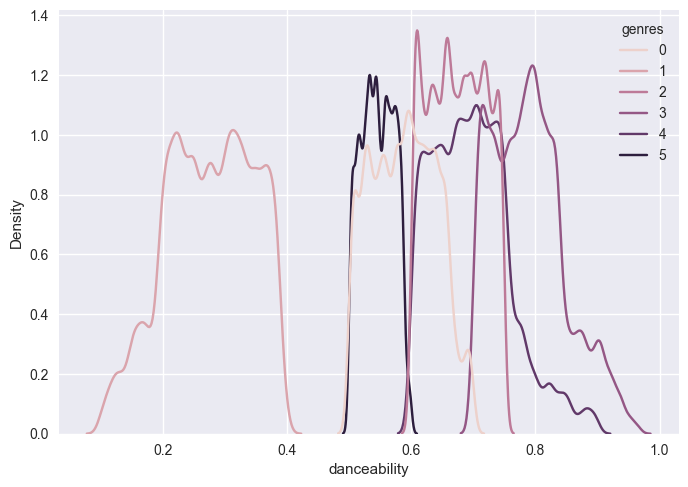

In [47]:
#Feature KDE
sns.kdeplot(data = nn_dataframe, x = 'danceability', hue = 'genres', bw_adjust=0.5)
print(target_dict)
print(nn_dataframe.columns)

### Train a model

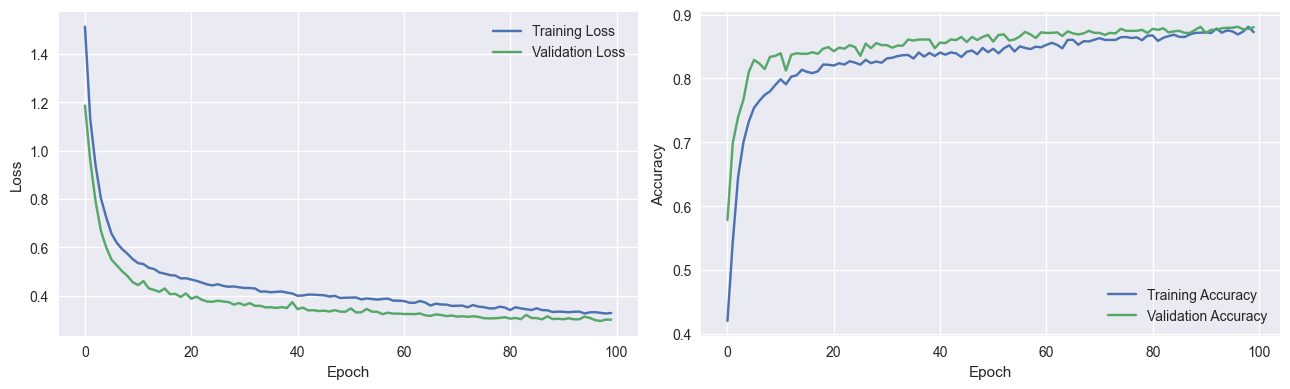

66/66 - 0s - loss: 0.3549 - accuracy: 0.8673 - 53ms/epoch - 803us/step


In [48]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(samples, target)

# Create a model
#model = create_model(input_shape=(13, 1))
# If additional features
model = create_model(input_shape=(15, 1))

# Train a model
trained_model = train_model(model, X_train, y_train)

# Evaluate on a test set
evaluate_model(model, X_test, y_test)

### Visualize

66/66 [==============================] - 0s 823us/step
Accuracy: 0.8672735984666986


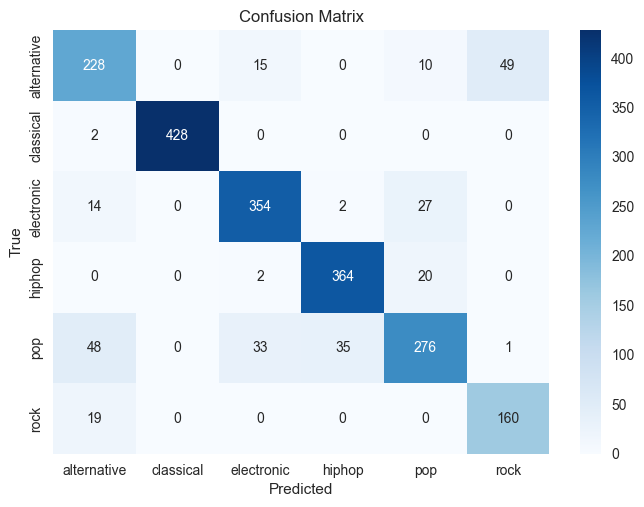

In [49]:
#Prediction accuracy using predict method
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
accuracy = np.mean(predicted_labels == y_test)
print('Accuracy:', accuracy)

#---Confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

#---Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_dict.keys(), yticklabels=target_dict.keys())

#---Set axis labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

#---Show the plot
plt.show()

In [ ]:
#Predictions probabilities in barplot style
def plot_predictions(predictions):

    num_predictions = len(predictions)
    num_subplots = 4  # Assuming 2 subplots per row, you can adjust as needed
    num_rows = (num_predictions + num_subplots - 1) // num_subplots

    fig, axs = plt.subplots(num_rows, num_subplots, figsize=(14, 2 * num_rows))

    for i, prediction in enumerate(predictions):
        row = i // num_subplots
        col = i % num_subplots

        ax = axs[row, col]
        ax.bar(range(len(prediction)), prediction)
        ax.set_xlabel('Categories')
        ax.set_ylabel('Probability')
        ax.set_title(f'Prediction {i+1}')

    # Adjust the spacing between subplots
    fig.tight_layout()

    # Display the plot
    plt.show()
    
plot_predictions(predictions.tolist()[:12])

### Save a model

In [ ]:
#Save model
# Save the weights
model.save_weights('models/optimizedata_model')

## ---------------------------------------------------------------------------------------------------------------------------------
## -------Neural network architecture optimization
## ---------------------------------------------------------------------------------------------------------------------------------

### Functions

In [ ]:
def prepare_data(genres):
    """
    prepare_data() generates necessary data as an input to a model.
    
    Args:
    - genres: a list of dataframes with features for every genre
    
    Returns:
    - samples: an array with input samples to a model
    - target: an array with output target to a model
    - nn_dataframe: input/output dataframe
    - target_dict: Encoded/Decoded target dictionary
    """
    
    # Feature columns used as input to a model
    ready_cols = ['danceability', 'energy', 'speechiness',
                  'acousticness', 'instrumentalness', 'liveness', 'valence']
    nready_cols = ['loudness', 'tempo', 'duration_ms',
                   'key', 'mode', 'time_signature']
    
    # Concatenate all dataframes and reset indexes
    df = pd.concat(genres, ignore_index=True).set_index('Track URI')
    ready_cols_df = df[ready_cols].reset_index()
    nready_cols_df = df[nready_cols]
    
    # Normalization objects
    scaler = MinMaxScaler()
    encoder = LabelEncoder()
    
    # Normalize features
    nready_cols_scaled = scaler.fit_transform(nready_cols_df.values)
    nready_cols_scaled_df = pd.DataFrame(nready_cols_scaled, columns=nready_cols)
    
    # Input to a model
    samples_df = pd.concat([ready_cols_df.drop(columns='Track URI'), nready_cols_scaled_df], axis=1)
    samples = samples_df.values
    
    # Target output from a model
    target = encoder.fit_transform(df['genres'].values)
    target_df = pd.DataFrame(target, columns=['genres'])
    
    # Target dictionary
    encoded_target = encoder.inverse_transform(target)
    target_dict = dict(zip(encoded_target, target))
    target_dict = dict(sorted(target_dict.items()))
    
    # Dataframe representation
    nn_dataframe = pd.concat([samples_df, target_df], axis=1)
    
    return samples, target, nn_dataframe, target_dict

def prepare_data_new_features(genres):
    """
    prepare_data() generates necessary data as an input to a model.
    
    Args:
    - genres: a list of dataframes with features for every genre
    
    Returns:
    - samples: an array with input samples to a model
    - target: an array with output target to a model
    - nn_dataframe: input/output dataframe
    - target_dict: Encoded/Decoded target dictionary
    """
    
    # Feature columns used as input to a model
    ready_cols = ['danceability', 'energy', 'speechiness',
                  'acousticness', 'instrumentalness', 'liveness', 
                  'valence', 'danceability_energy_ratio', 'danceability_valence_ratio']
    nready_cols = ['loudness', 'tempo', 'duration_ms',
                   'key', 'mode', 'time_signature']
    
    # Concatenate all dataframes and reset indexes
    df = pd.concat(genres, ignore_index=True).set_index('Track URI')
    ready_cols_df = df[ready_cols].reset_index()
    nready_cols_df = df[nready_cols]
    
    # Normalization objects
    scaler = MinMaxScaler()
    encoder = LabelEncoder()
    
    # Normalize features
    nready_cols_scaled = scaler.fit_transform(nready_cols_df.values)
    nready_cols_scaled_df = pd.DataFrame(nready_cols_scaled, columns=nready_cols)
    
    # Input to a model
    samples_df = pd.concat([ready_cols_df.drop(columns='Track URI'), nready_cols_scaled_df], axis=1)
    samples = samples_df.values
    
    # Target output from a model
    target = encoder.fit_transform(df['genres'].values)
    target_df = pd.DataFrame(target, columns=['genres'])
    
    # Target dictionary
    encoded_target = encoder.inverse_transform(target)
    target_dict = dict(zip(encoded_target, target))
    target_dict = dict(sorted(target_dict.items()))
    
    # Dataframe representation
    nn_dataframe = pd.concat([samples_df, target_df], axis=1)
    
    return samples, target, nn_dataframe, target_dict

def model_builder(hp):
#--------------------------------------------------------------------------------
#---model_builder() allows to build model architecture for hyperparameter tuning
#--------------------------------------------------------------------------------

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape = (13, 1)))
    
    hp_activation = hp.Choice('activation', values = ['relu', 'tanh'])
    hp_layer_1 = hp.Int('layer_1', min_value = 16, max_value = 128, step = 16)
    hp_layer_2 = hp.Int('layer_2', min_value = 0, max_value = 128, step = 16)
              
    model.add(tf.keras.layers.Dense(units = hp_layer_1, activation = hp_activation))
    model.add(tf.keras.layers.Dense(units = hp_layer_2, activation = hp_activation))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(6, activation = 'softmax'))
              
    model.compile(optimizer = tf.keras.optimizers.Adam(),
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics = ['accuracy'])
              
    return model

#---Optimizator definition
def tuner(tuner):
    stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
    tuner.search(X_train, y_train, epochs = 100, validation_split = 0.2, callbacks = [stop_early])
    #tuner.results_summary()
    best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
    model = tuner.hypermodel.build(best_hps)
    model.summary()
    
    return model

### Load training data

#### Load raw data

In [ ]:
#Original Genres data
hiphop = pd.read_csv('GenresDatasetGenerator/Genres/HipHopGenre.csv')
rock = pd.read_csv('GenresDatasetGenerator/Genres/RockGenre.csv')
classical = pd.read_csv('GenresDatasetGenerator/Genres/ClassicalGenre.csv')
electronic = pd.read_csv('GenresDatasetGenerator/Genres/ElectronicGenre.csv')
alternative = pd.read_csv('GenresDatasetGenerator/Genres/AlternativeGenre.csv')
pop = pd.read_csv('GenresDatasetGenerator/Genres/PopGenre.csv')

genres = [hiphop, rock, classical, electronic, alternative, pop]

#### Load modified data - use "Neural network training on a modified genre datasets" module

#### Preprocess and split raw data

In [ ]:
# Create and preprocess training data
samples, target, nn_dataframe, target_dict = prepare_data(genres)
# Data split
X_train, X_test, y_train, y_test = train_test_split(samples, target)

#### Preprocess and split modified data

In [ ]:
# Create and preprocess training data
samples, target, nn_dataframe, target_dict = prepare_data_new_features(genres)
# Data split
X_train, X_test, y_train, y_test = train_test_split(samples, target)

### Choose a tuner and build a model

In [ ]:
#---Available tuners
hb_tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy',
                     max_epochs = 100,
                     factor = 3,
                     directory = 'keras-tuner',
                     overwrite = True,
                     project_name = 'test')

rs_tuner = kt.RandomSearch(model_builder,
                         objective="val_accuracy",
                         max_trials=10,
                         executions_per_trial=2,
                         overwrite=True,
                         directory="keras-tuner",
                         project_name="testt")

gs_tuner = kt.GridSearch(model_builder,
                         objective = 'val_accuracy',
                         max_trials = 20,
                         directory = 'keras-tuner',
                         overwrite = True,
                         project_name = 'best_model_gstuner')

#Build a model defined by 
model = tuner(gs_tuner)

### Save a model

In [ ]:
#Save model
# Save the weights
model.save_weights('models/hptuner_model')

## ---------------------------------------------------------------------------------------------------------------------------------
## -------Predictions
## ---------------------------------------------------------------------------------------------------------------------------------

### Functions

In [ ]:
def create_model(input_shape):
    """
    create_model() allows customizing and building a model.
    
    Args:
    - input_shape: shape of the input
    
    Returns:
    - model: neural network model
    """
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    
    # Compiler
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    model.compile(optimizer='adam',
                  loss=loss_func,
                  metrics=['accuracy'])
    
    return model

#Predictions probabilities in barplot style
def plot_predictions(predictions):

    num_predictions = len(predictions)
    num_subplots = 4  # Assuming 2 subplots per row, you can adjust as needed
    num_rows = (num_predictions + num_subplots - 1) // num_subplots

    fig, axs = plt.subplots(num_rows, num_subplots, figsize=(14, 2 * num_rows))

    for i, prediction in enumerate(predictions):
        row = i // num_subplots
        col = i % num_subplots

        ax = axs[row, col]
        ax.bar(range(len(prediction)), prediction)
        ax.set_xlabel('Categories')
        ax.set_ylabel('Probability')
        ax.set_title(f'Prediction {i+1}')

    # Adjust the spacing between subplots
    fig.tight_layout()

    # Display the plot
    plt.show()
    
def prepare_data_new_features(genres):
    """
    prepare_data() generates necessary data as an input to a model.
    
    Args:
    - genres: a list of dataframes with features for every genre
    
    Returns:
    - samples: an array with input samples to a model
    - target: an array with output target to a model
    - nn_dataframe: input/output dataframe
    - target_dict: Encoded/Decoded target dictionary
    """
    
    # Feature columns used as input to a model
    ready_cols = ['danceability', 'energy', 'speechiness',
                  'acousticness', 'instrumentalness', 'liveness', 
                  'valence', 'danceability_energy_ratio', 'danceability_valence_ratio']
    nready_cols = ['loudness', 'tempo', 'duration_ms',
                   'key', 'mode', 'time_signature']
    
    # Concatenate all dataframes and reset indexes
    df = pd.concat(genres, ignore_index=True).set_index('Track URI')
    ready_cols_df = df[ready_cols].reset_index()
    nready_cols_df = df[nready_cols]
    
    # Normalization objects
    scaler = MinMaxScaler()
    encoder = LabelEncoder()
    
    # Normalize features
    nready_cols_scaled = scaler.fit_transform(nready_cols_df.values)
    nready_cols_scaled_df = pd.DataFrame(nready_cols_scaled, columns=nready_cols)
    
    # Input to a model
    samples_df = pd.concat([ready_cols_df.drop(columns='Track URI'), nready_cols_scaled_df], axis=1)
    samples = samples_df.values
    
    # Target output from a model
    target = encoder.fit_transform(df['genres'].values)
    target_df = pd.DataFrame(target, columns=['genres'])
    
    # Target dictionary
    encoded_target = encoder.inverse_transform(target)
    target_dict = dict(zip(encoded_target, target))
    target_dict = dict(sorted(target_dict.items()))
    
    # Dataframe representation
    nn_dataframe = pd.concat([samples_df, target_df], axis=1)
    
    return samples, target, nn_dataframe, target_dict

#Predictions for unknown data
def data_prep(df):
    
    ready_cols = ['danceability', 'energy', 'speechiness', 
                  'acousticness', 'instrumentalness', 'liveness', 'valence']
    nready_cols = ['loudness', 'tempo', 'duration_ms', 
                   'key', 'mode', 'time_signature']

    #---Concatenate all and reset indexes
    df = df.set_index('Track URI')
    ready_cols_df = df[ready_cols].reset_index()
    nready_cols_df = df[nready_cols]

    #---Normalization objects
    scaler = MinMaxScaler()
    encoder = LabelEncoder()

    #---Normalize features
    #------nready_cols_scaled - transformed data
    #------nready_cols_scaled_df - dataframe
    nready_cols_scaled = scaler.fit_transform(nready_cols_df.values) 
    nready_cols_scaled_df = pd.DataFrame(nready_cols_scaled, columns = nready_cols)
    
    #---Input to a model
    samples_df = pd.concat([ready_cols_df.drop(columns = 'Track URI'), nready_cols_scaled_df], axis = 1)
    samples = samples_df.values
    
    return samples, samples_df

#Predictions for unknown data
def data_prep_m(df):
    
    ready_cols = ['danceability', 'energy', 'speechiness', 
                  'acousticness', 'instrumentalness', 'liveness', 'valence',
                  'danceability_energy_ratio', 'danceability_valence_ratio']
    nready_cols = ['loudness', 'tempo', 'duration_ms', 
                   'key', 'mode', 'time_signature']

    #---Concatenate all and reset indexes
    df = df.set_index('Track URI')
    ready_cols_df = df[ready_cols].reset_index()
    nready_cols_df = df[nready_cols]

    #---Normalization objects
    scaler = MinMaxScaler()
    encoder = LabelEncoder()

    #---Normalize features
    #------nready_cols_scaled - transformed data
    #------nready_cols_scaled_df - dataframe
    nready_cols_scaled = scaler.fit_transform(nready_cols_df.values) 
    nready_cols_scaled_df = pd.DataFrame(nready_cols_scaled, columns = nready_cols)
    
    #---Input to a model
    samples_df = pd.concat([ready_cols_df.drop(columns = 'Track URI'), nready_cols_scaled_df], axis = 1)
    samples = samples_df.values
    
    return samples, samples_df

### Create and load a model

In [ ]:
#Create a model
model = create_model(input_shape=(15, 1))
#Load model
# Restore the weights
model.load_weights('models/optimizedata_model')
#Show summary
model.summary()

### Model predictions on a test data in barplot style

#### For test data use neural network modules

#### Predict on a test set

In [ ]:
#Prediction accuracy using predict method
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
accuracy = np.mean(predicted_labels == y_test)
print('Accuracy:', accuracy)

#---Confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

#---Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_dict.keys(), yticklabels=target_dict.keys())

#---Set axis labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

#---Show the plot
plt.show()


#### Plot predictions probabilities

In [ ]:
#Plot predictions
plot_predictions(predictions.tolist()[:12])

### Model predictions for unknown data

#### Prediction barplot for song

In [ ]:
#Must be a song
data = pd.read_csv('GenresDatasetGenerator/Songs/m_PorscheTopless.csv')

#Preprocess data

#For raw data
#test_samples, test_samples_df = data_prep(data)

#For modified data
test_samples, test_samples_df = data_prep_m(data)

#Predict
predictions = model.predict(test_samples)

target_dict = {'Alternative': 0, 
               'Classical': 1, 
               'Electronic': 2, 
               'HipHop': 3, 
               'Pop': 4, 
               'Rock': 5}

labels = list(target_dict.keys())
indices = list(target_dict.values())

# Create a bar plot
plt.bar(indices, predictions.flatten())

# Set the tick labels and title
plt.xticks(indices, labels)
plt.xlabel('Genres')
plt.ylabel('Prediction Probability')
plt.title('Predicted Probabilities for Genres')

# Display the plot
plt.show()

#### Prediction barplots for playlist

In [ ]:
#Must be a playlist
data = pd.read_csv('GenresDatasetGenerator/Albums/m_ToryLanez.csv')

#Preprocess data

#For raw data
#test_samples, test_samples_df = data_prep(data)

#For modified data
test_samples, test_samples_df = data_prep_m(data)

#Predict
predictions = model.predict(test_samples)

target_dict = {'Alternative': 0, 
               'Classical': 1, 
               'Electronic': 2, 
               'HipHop': 3, 
               'Pop': 4, 
               'Rock': 5}

#Plot predictions
plot_predictions(predictions)

#### Histogram for genres count

In [ ]:
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels_keys = [key for value in predicted_labels for key, val in target_dict.items() if val == value]
sns.histplot(data = predicted_labels_keys, discrete = True)

#### Model prediction uncertainty

In [ ]:
#Predictions probabilities dataframe
prediction_df = pd.DataFrame(data = predictions, columns = target_dict.keys())
#prediction_df

#Uncertainty as an difference between two highest probabilities
uncertainty = []
for i in range(prediction_df.shape[0]):
    pred_uncertainty = prediction_df.iloc[i].sort_values(ascending = False)[0] - prediction_df.iloc[i].sort_values(ascending = False)[1]
    uncertainty.append(pred_uncertainty)

uncertainty_df = pd.DataFrame(data = uncertainty, columns = ['Uncertainty Value'])
#uncertainty_df = uncertainty_df.sort_values(by = 'Uncertainty Value', ascending = False) # No need for sorting, seaborn handle this
#uncertainty_df

sns.kdeplot(data = uncertainty_df, x = 'Uncertainty Value', bw_adjust=0.2)